In [22]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the simage points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [23]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree
from dbfread import DBF

In [24]:
#Load shapefile

my_shapefile_path = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
my_shp = gpd.read_file(my_shapefile_path)
#print(my_shp)

In [25]:
#Access to Mapillary API

clienttoken = "MLY|6271859919532158|486bcdece7a665eb89a5803f2994b4c9"
clientsecret = "MLY|6271859919532158|891f85315dab6cea6fce4efaac3f1683"
#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)



In [26]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
print(df_lines)


#df_lines = gpd.GeoDataFrame(TF)



               ID                                           geometry
47      174472823  LINESTRING (12.54255 55.66452, 12.54272 55.66479)
188     174472925  LINESTRING (12.54329 55.66718, 12.54352 55.667...
515     174477311  LINESTRING (12.56242 55.67385, 12.56234 55.67394)
845     174474161  LINESTRING (12.54380 55.67105, 12.54376 55.67109)
849     174477032  LINESTRING (12.56357 55.67126, 12.56361 55.67128)
...           ...                                                ...
301660  174474898  LINESTRING (12.54812 55.66269, 12.54809 55.66274)
301676  174475046  LINESTRING (12.55384 55.66429, 12.55399 55.66431)
301682  174475045  LINESTRING (12.55396 55.66422, 12.55400 55.664...
301756  174475042  LINESTRING (12.55399 55.66431, 12.55398 55.664...
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)

[2442 rows x 2 columns]


<Axes: >

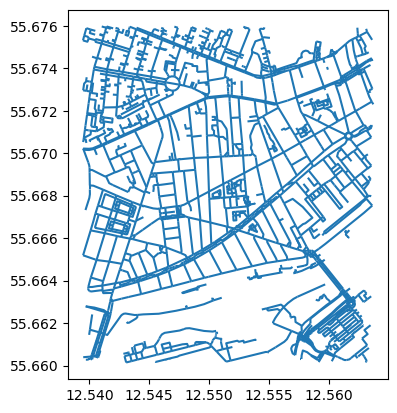

In [27]:

df_lines["geometry"].plot()

/tmp/ipykernel_82613/3281745053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer


<Axes: >

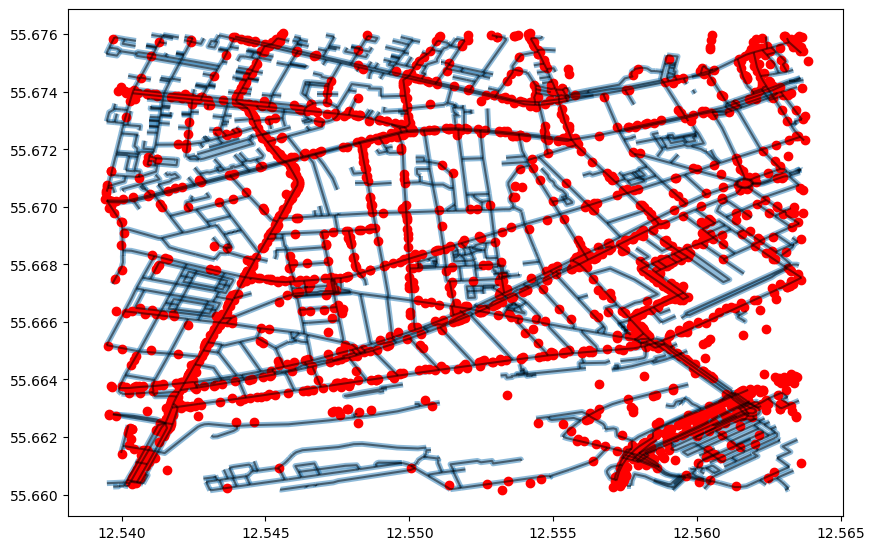

In [28]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer
#df_lines["geometry"].plot(ax=ax,alpha=0.5)  #W/o buffer
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")



## Non-assigned Pictures

/tmp/ipykernel_82613/898194467.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)
/tmp/ipykernel_82613/898194467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)


251


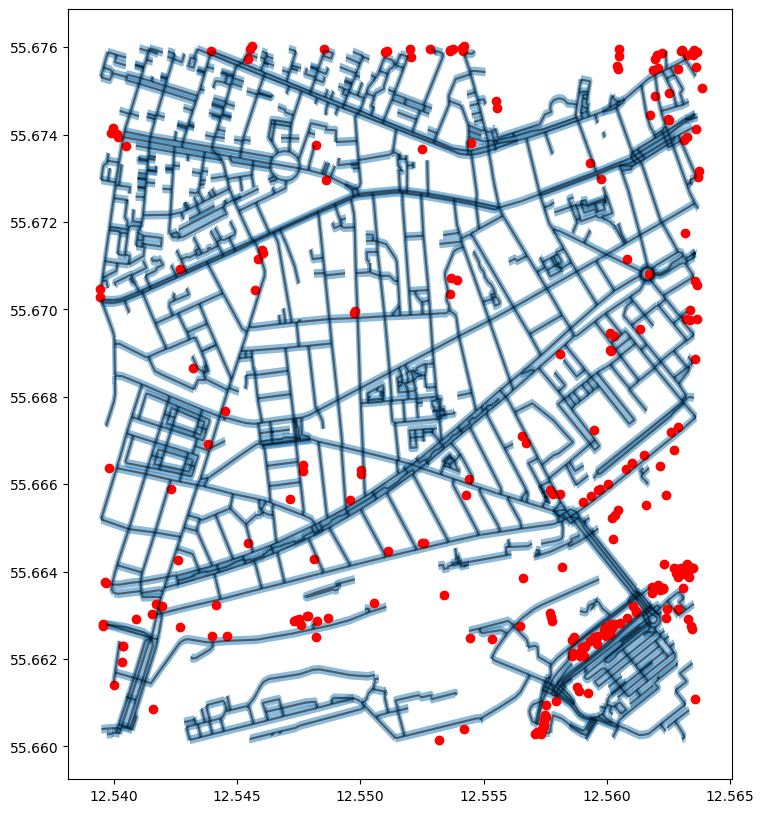

In [29]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
pointInPoly[pointInPoly['index_right'].isna()].plot(ax=ax,color = "r")

print(len(pointInPoly[pointInPoly['index_right'].isna()]))


In [30]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,1426710331021001,POINT (12.55763 55.67278),257808.0,174476219.0
1,1840222526151944,POINT (12.56358 55.67549),168136.0,174477478.0
2,4460230530672784,POINT (12.54995 55.67274),60925.0,174476056.0
2,4460230530672784,POINT (12.54995 55.67274),147454.0,174476301.0
2,4460230530672784,POINT (12.54995 55.67274),177393.0,174476059.0
...,...,...,...,...
1975,1431796510490000,POINT (12.55721 55.66552),287554.0,174475173.0
1976,2846858482244122,POINT (12.55291 55.66655),86795.0,174475137.0
1976,2846858482244122,POINT (12.55291 55.66655),167023.0,174475134.0
1977,2995038177407651,POINT (12.56182 55.66365),NaN,NaN


<Axes: >

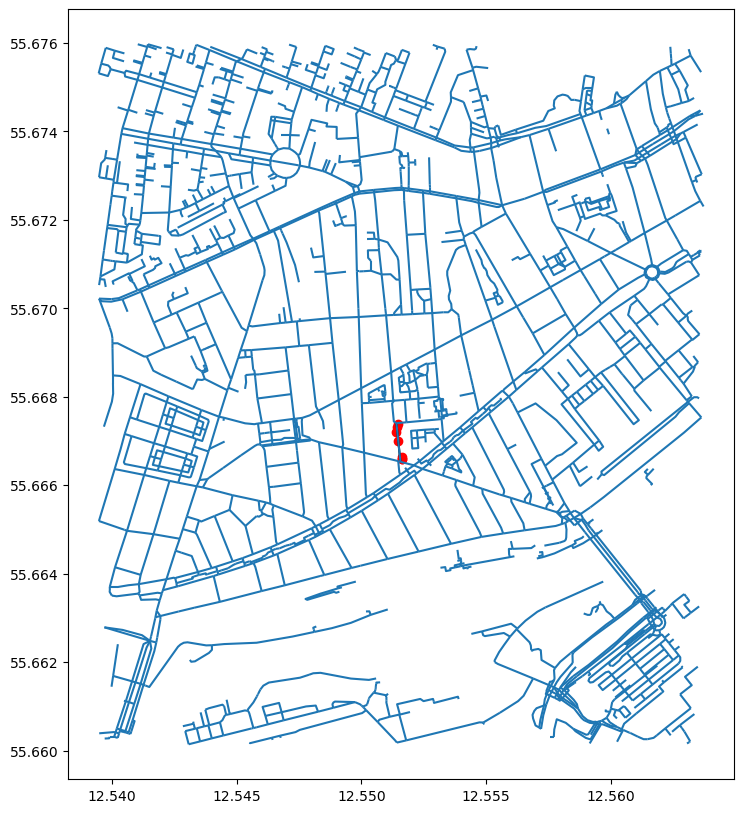

In [31]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

(55.660144, 55.675971)

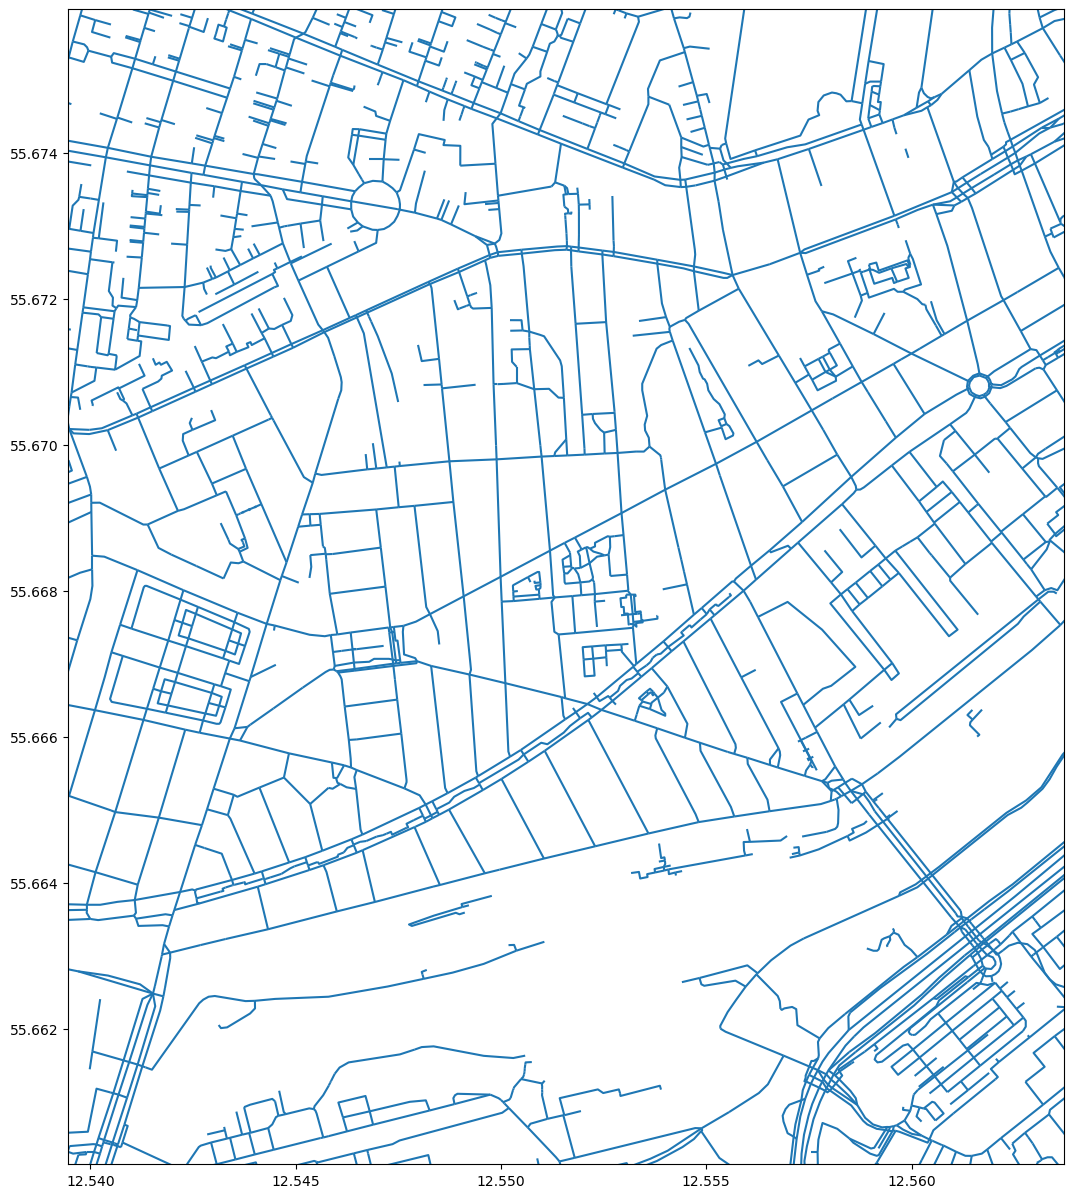

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)

In [33]:
#Shapefile gives edgeUID, osmId and geometry 
shp = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
strava_shape = gpd.read_file(shp)
#print(strava_shape)

#csv-file gives edge_uid, actitivity type, date, total_trip_count etc. 
strava_csv = pd.read_csv("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.csv")
#print(strava_csv)

#dbf-file gives edgeUID and osmId 
dbf = DBF('/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.dbf')
frame = pd.DataFrame(iter(dbf))
#print(frame)

#textfile ???
file1 = open("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.txt","r")
#print(file1)

In [34]:

csv_df = {"ID": strava_csv["edge_uid"], "Activity": strava_csv["total_trip_count"]}
# "Month": strava_csv["month"]
csv_df = pd.DataFrame(data=csv_df)
csv_df = csv_df.dropna(subset=["ID"])
csv_df["Summed activity"] = csv_df.groupby("ID")["Activity"].transform("sum")
collapsed_df = csv_df.drop_duplicates(subset=["ID"], keep="first")
filtered_df = collapsed_df[collapsed_df["ID"].isin(df_lines["ID"])]

activity_df = pd.DataFrame({"ID": filtered_df["ID"], "Activity": filtered_df["Summed activity"]})

list_ID_ac = activity_df["ID"].tolist()
list_ID_line = df_lines["ID"].tolist()
print((len(list_ID_ac),len(list_ID_line)))

print(activity_df)


(1901, 2442)
                ID  Activity
3552     174476152      1260
4284     174476138       725
5205     174472857     11885
5217     174475361     11190
6086     174474204      5855
...            ...       ...
1662088  174475728     11890
1662100  174476604     10050
1664757  174474907       565
1665491  174474571      4670
1665515  174476242      2935

[1901 rows x 2 columns]


In [35]:
merged_df = pd.merge(pointInPoly, activity_df, left_on="ID_right", right_on="ID")
merged_df

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1426710331021001,POINT (12.55763 55.67278),257808.0,174476219.0,174476219,5935
1,1378122352560608,POINT (12.55818 55.67287),257808.0,174476219.0,174476219,5935
2,2951619708495542,POINT (12.55873 55.67302),257808.0,174476219.0,174476219,5935
3,3452106228409017,POINT (12.55826 55.67290),257808.0,174476219.0,174476219,5935
4,2617292185233882,POINT (12.55956 55.67307),257808.0,174476219.0,174476219,5935
...,...,...,...,...,...,...
2493,3305404249562267,POINT (12.55906 55.66504),169471.0,174475731.0,174475731,19790
2494,5783770995025901,POINT (12.55896 55.66181),229318.0,174475348.0,174475348,2470
2495,1247755896071267,POINT (12.54007 55.66909),9370.0,174473891.0,174473891,6755
2496,4533934469969210,POINT (12.55757 55.66155),242423.0,174475331.0,174475331,520


In [36]:
isnull = merged_df.index[merged_df["Activity"].isnull()].tolist()

isnull

[]

In [46]:
result = merged_df.drop_duplicates(['ID_right'],keep='first')
result

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1426710331021001,POINT (12.55763 55.67278),257808.0,174476219.0,174476219,5935
9,1840222526151944,POINT (12.56358 55.67549),168136.0,174477478.0,174477478,3920
15,4460230530672784,POINT (12.54995 55.67274),60925.0,174476056.0,174476056,11045
28,4460230530672784,POINT (12.54995 55.67274),147454.0,174476301.0,174476301,12585
37,4460230530672784,POINT (12.54995 55.67274),177393.0,174476059.0,174476059,10720
...,...,...,...,...,...,...
2493,3305404249562267,POINT (12.55906 55.66504),169471.0,174475731.0,174475731,19790
2494,5783770995025901,POINT (12.55896 55.66181),229318.0,174475348.0,174475348,2470
2495,1247755896071267,POINT (12.54007 55.66909),9370.0,174473891.0,174473891,6755
2496,4533934469969210,POINT (12.55757 55.66155),242423.0,174475331.0,174475331,520


In [50]:
reset = result.reset_index()
reset.pop("index")
reset

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1426710331021001,POINT (12.55763 55.67278),257808.0,174476219.0,174476219,5935
1,1840222526151944,POINT (12.56358 55.67549),168136.0,174477478.0,174477478,3920
2,4460230530672784,POINT (12.54995 55.67274),60925.0,174476056.0,174476056,11045
3,4460230530672784,POINT (12.54995 55.67274),147454.0,174476301.0,174476301,12585
4,4460230530672784,POINT (12.54995 55.67274),177393.0,174476059.0,174476059,10720
...,...,...,...,...,...,...
890,3305404249562267,POINT (12.55906 55.66504),169471.0,174475731.0,174475731,19790
891,5783770995025901,POINT (12.55896 55.66181),229318.0,174475348.0,174475348,2470
892,1247755896071267,POINT (12.54007 55.66909),9370.0,174473891.0,174473891,6755
893,4533934469969210,POINT (12.55757 55.66155),242423.0,174475331.0,174475331,520
